In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import re
import nltk
import tensorflow as tf
from sklearn.utils import resample
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Conv1D, GlobalMaxPooling1D, LSTM
from keras.models import save_model
import joblib
import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## *Loading Dataset*

In [2]:
data1=pd.read_csv("/content/goemotions_1.csv",encoding='utf-8')
data2=pd.read_csv("/content/goemotions_2.csv",encoding='utf-8')
data3=pd.read_csv("/content/goemotions_3.csv",encoding='utf-8')
data4=pd.read_csv("/content/DailyDialog.csv",encoding='utf-8')
data=pd.concat([data1,data2,data3], ignore_index=True)
print(data1.shape)
print(data2.shape)
print(data3.shape)
data.head()

(69995, 37)
(69997, 37)
(71219, 37)


,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1548381039,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1548084169,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1546427744,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1547965054,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1546668601,2,False,0,...,0,0,0,0,0,0,0,0,0,1


## *EDA*

In [3]:
data=data.drop(data.iloc[:,1:9],axis=1)
data['sentiment']=data.drop('text',axis=1).idxmax(axis=1)
data=data.drop(data.iloc[:,1:29],axis=1)
data=pd.concat([data,data4],ignore_index=True)
data.head()

,text,sentiment
0,That game hurt.,sadness
1,>sexuality shouldn’t be a grouping category I...,admiration
2,"You do right, if you don't care then fuck 'em!",neutral
3,Man I love reddit.,love
4,"[NAME] was nowhere near them, he was by the Fa...",neutral


In [4]:
sentiment_map = {
    'admiration': 'happy', 'amusement': 'happy', 'anger': 'angry', 'annoyance': 'angry',
    'approval': 'happy', 'caring': 'happy', 'confusion': 'surprise', 'curiosity': 'surprise',
    'desire': 'happy', 'disappointment': 'sad', 'disapproval': 'sad', 'disgust': 'angry',
    'embarrassment': 'angry', 'excitement': 'happy', 'fear': 'fear', 'gratitude': 'happy',
    'grief': 'sad', 'joy': 'happy', 'love': 'happy', 'nervousness': 'fear', 'neutral': 'neutral',
    'optimism': 'happy', 'pride': 'happy', 'realization': 'surprise', 'relief': 'happy',
    'remorse': 'sad', 'sadness': 'sad', 'surprise': 'surprise'
}

data['sentiment'] = data['sentiment'].map(sentiment_map)
data.head()

,text,sentiment
0,That game hurt.,sad
1,>sexuality shouldn’t be a grouping category I...,happy
2,"You do right, if you don't care then fuck 'em!",neutral
3,Man I love reddit.,happy
4,"[NAME] was nowhere near them, he was by the Fa...",neutral


In [5]:
data['sentiment'].value_counts()

,count
sentiment,
happy,85167
neutral,57544
angry,27284
sad,24008
surprise,22904
fear,5631


In [6]:
px.bar(data['sentiment'].value_counts(),title='Sentiment Distribution',labels={'index':'Sentiment','value':'Count'})

In [7]:
data_happy = data[data.sentiment == 'happy']
data_neutral = data[data.sentiment == 'neutral']
data_angry = data[data.sentiment == 'angry']
data_surprise = data[data.sentiment == 'surprise']
data_sad = data[data.sentiment == 'sad']
data_fear = data[data.sentiment == 'fear']

data_neutral_upsampled = resample(data_neutral, replace=True, n_samples=85167, random_state=123)
data_angry_upsampled = resample(data_angry, replace=True, n_samples=85167, random_state=123)
data_surprise_upsampled = resample(data_surprise, replace=True, n_samples=85167, random_state=123)
data_sad_upsampled = resample(data_sad, replace=True, n_samples=85167, random_state=123)
data_fear_upsampled = resample(data_fear, replace=True, n_samples=85167, random_state=123)

data_upsampled = pd.concat([data_happy, data_neutral_upsampled, data_angry_upsampled, data_surprise_upsampled, data_sad_upsampled, data_fear_upsampled])

data=data_upsampled.reset_index(drop=True)

In [8]:
data['sentiment'].value_counts()

,count
sentiment,
happy,85167
neutral,85167
angry,85167
surprise,85167
sad,85167
fear,85167


In [9]:
px.bar(data['sentiment'].value_counts(),title='Sentiment Distribution',labels={'index':'Sentiment','value':'Count'})

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511002 entries, 0 to 511001
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       511002 non-null  object
 1   sentiment  511002 non-null  object
dtypes: object(2)
memory usage: 7.8+ MB


## *Text Preprocessing*

*Lowercasing The Text*

In [11]:
data["processed_text"] = data["text"].str.lower()
data.head()

,text,sentiment,processed_text
0,>sexuality shouldn’t be a grouping category I...,happy,>sexuality shouldn’t be a grouping category i...
1,Man I love reddit.,happy,man i love reddit.
2,Right? Considering it’s such an important docu...,happy,right? considering it’s such an important docu...
3,That's crazy; I went to a super [RELIGION] hig...,happy,that's crazy; i went to a super [religion] hig...
4,that's adorable asf,happy,that's adorable asf


*Handling Special Character*

In [12]:
def remove_special_character(text):
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return cleaned_text

data['processed_text']=data['processed_text'].apply(lambda text:remove_special_character(text))
data.head()

,text,sentiment,processed_text
0,>sexuality shouldn’t be a grouping category I...,happy,sexuality shouldnt be a grouping category it ...
1,Man I love reddit.,happy,man i love reddit
2,Right? Considering it’s such an important docu...,happy,right considering its such an important docume...
3,That's crazy; I went to a super [RELIGION] hig...,happy,thats crazy i went to a super religion high sc...
4,that's adorable asf,happy,thats adorable asf


*Removing URLs*

In [13]:
def remove_URL(sample):
    return re.sub(r"http\S+", "", sample)

data['processed_text']=data['processed_text'].apply(lambda text: remove_URL(text))
data.head()

,text,sentiment,processed_text
0,>sexuality shouldn’t be a grouping category I...,happy,sexuality shouldnt be a grouping category it ...
1,Man I love reddit.,happy,man i love reddit
2,Right? Considering it’s such an important docu...,happy,right considering its such an important docume...
3,That's crazy; I went to a super [RELIGION] hig...,happy,thats crazy i went to a super religion high sc...
4,that's adorable asf,happy,thats adorable asf


*Handling Emojis*

In [14]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

data['processed_text']=data['processed_text'].apply(lambda text: remove_emoji(text))
data.head()

,text,sentiment,processed_text
0,>sexuality shouldn’t be a grouping category I...,happy,sexuality shouldnt be a grouping category it ...
1,Man I love reddit.,happy,man i love reddit
2,Right? Considering it’s such an important docu...,happy,right considering its such an important docume...
3,That's crazy; I went to a super [RELIGION] hig...,happy,thats crazy i went to a super religion high sc...
4,that's adorable asf,happy,thats adorable asf


*Handling Emoticons*

In [15]:
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

In [16]:
def remove_emoticons(text):
    emoticons_pattern=re.compile(u'('+u'|'.join(i for i in EMOTICONS)+u')')
    return emoticons_pattern.sub(r'',text)

data['processed_text']=data['processed_text'].apply(lambda text: remove_emoticons(text))
data.head()

,text,sentiment,processed_text
0,>sexuality shouldn’t be a grouping category I...,happy,sexuality shouldnt be a grouping category it ...
1,Man I love reddit.,happy,man i love reddit
2,Right? Considering it’s such an important docu...,happy,right considering its such an important docume...
3,That's crazy; I went to a super [RELIGION] hig...,happy,thats crazy i went to a super religion high sc...
4,that's adorable asf,happy,thats adorable asf


In [17]:
print(len(data['text'][2]))

135


In [18]:
print(len(data['processed_text'][2]))

128


*Removing Stopwords*

In [19]:
stopwords = set([
    'a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an', 'and',
    'any', 'are', 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below',
    'between', 'both', 'by', 'can', 'd', 'did', 'do', 'does', 'doing', 'down',
    'during', 'each', 'em', 'few', 'for', 'from', 'further', 'had', 'has', 'have',
    'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his',
    'how', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'itself', 'just', 'll', 'm',
    'ma', 'me', 'more', 'most', 'my', 'myself', 'now', 'o', 'of', 'on', 'once',
    'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'own', 're', 's',
    'same', 'she', "shes", 'should', "shouldve", 'so', 'some', 'such', 't', 'than',
    'that', "thatll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there',
    'these', 'they', 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up',
    've', 'very', 'was', 'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who',
    'whom', 'why', 'will', 'with', 'won', 'y', 'you', "youd", "youll", "youre", "youve",
    'your', 'yours', 'yourself', 'yourselves', 'lit', 'sick', 'bae', 'fam', 'yolo', 'goat',
    'woke', 'salty', 'fomo', 'squad', 'flex', 'chill', 'slay', 'savage', 'af', 'hundo', 'gucci',
    'dope', 'swag', 'thirsty'
])


def remove_stopwords(text):
  return " ".join([i for i in str(text).split() if i not in stopwords])

data['processed_text']=data['processed_text'].apply(lambda text: remove_stopwords(text))
data.head()

,text,sentiment,processed_text
0,>sexuality shouldn’t be a grouping category I...,happy,sexuality shouldnt grouping category makes dif...
1,Man I love reddit.,happy,man love reddit
2,Right? Considering it’s such an important docu...,happy,right considering important document know damn...
3,That's crazy; I went to a super [RELIGION] hig...,happy,thats crazy went super religion high school th...
4,that's adorable asf,happy,thats adorable asf


In [20]:
print(len(data['text'][2]))

135


In [21]:
print(len(data['processed_text'][2]))

85


*Lemmatization*

In [22]:
nltk.download('punkt_tab')

lemma=WordNetLemmatizer()
def lemmatize_text(text):
  text=[lemma.lemmatize(i) for i in word_tokenize(text)]
  return " ".join(text)

data['processed_text']=data['processed_text'].apply(lambda text: lemmatize_text(text))
data.head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,text,sentiment,processed_text
0,>sexuality shouldn’t be a grouping category I...,happy,sexuality shouldnt grouping category make diff...
1,Man I love reddit.,happy,man love reddit
2,Right? Considering it’s such an important docu...,happy,right considering important document know damn...
3,That's crazy; I went to a super [RELIGION] hig...,happy,thats crazy went super religion high school th...
4,that's adorable asf,happy,thats adorable asf


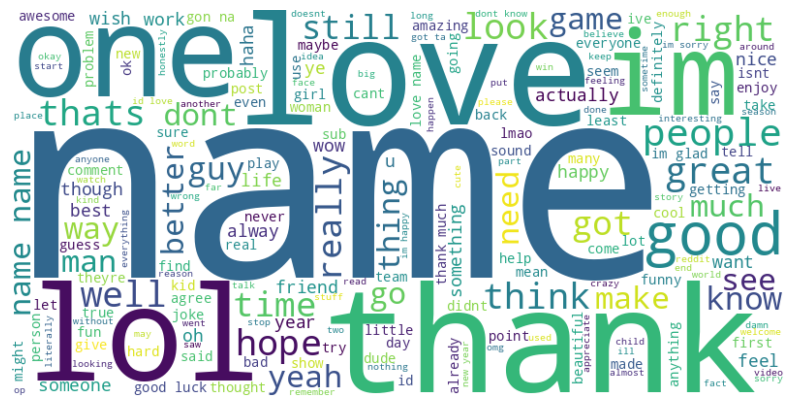

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

happy_text = data[data['sentiment'] == 'happy']['processed_text'].str.cat(sep=' ')

# Créer le nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(happy_text)

# Afficher le nuage de mots
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


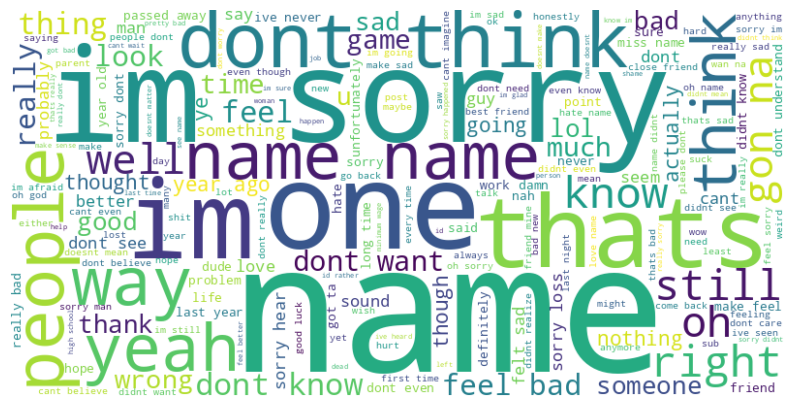

In [24]:
happy_text = data[data['sentiment'] == 'sad']['processed_text'].str.cat(sep=' ')

# Créer le nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(happy_text)

# Afficher le nuage de mots
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


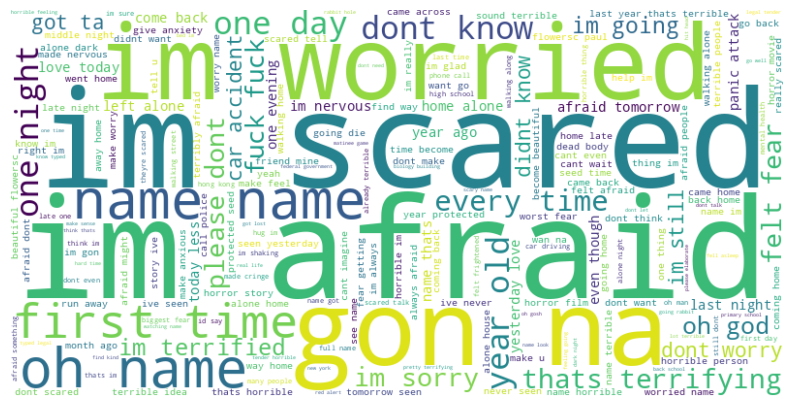

In [25]:
happy_text = data[data['sentiment'] == 'fear']['processed_text'].str.cat(sep=' ')

# Créer le nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(happy_text)

# Afficher le nuage de mots
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


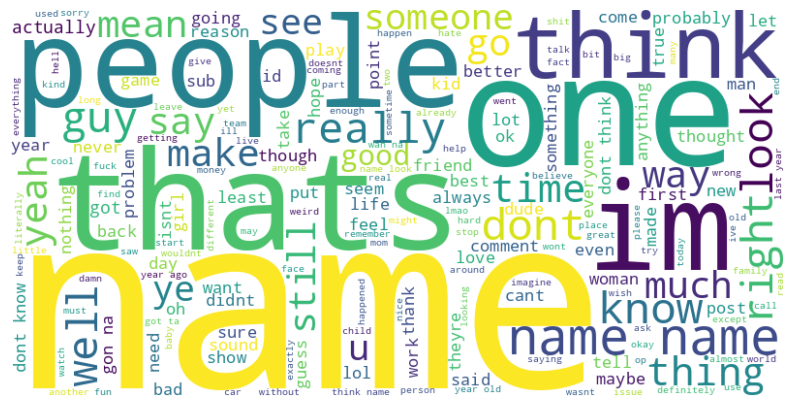

In [26]:
happy_text = data[data['sentiment'] == 'neutral']['processed_text'].str.cat(sep=' ')

# Créer le nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(happy_text)

# Afficher le nuage de mots
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


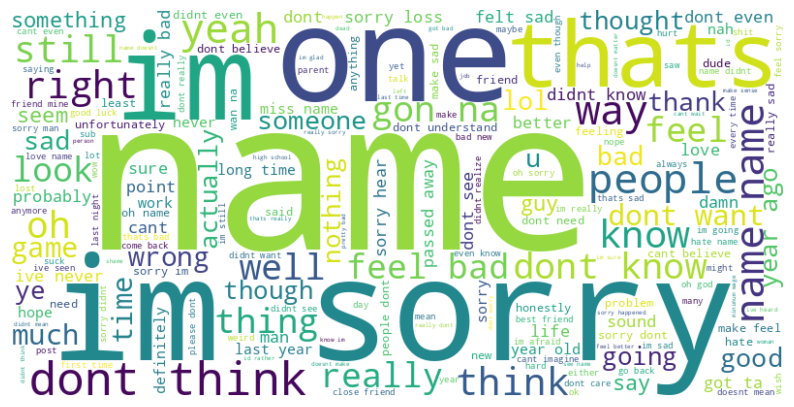

In [27]:
happy_text = data[data['sentiment'] == 'sad']['processed_text'].str.cat(sep=' ')

# Créer le nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(happy_text)

# Afficher le nuage de mots
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


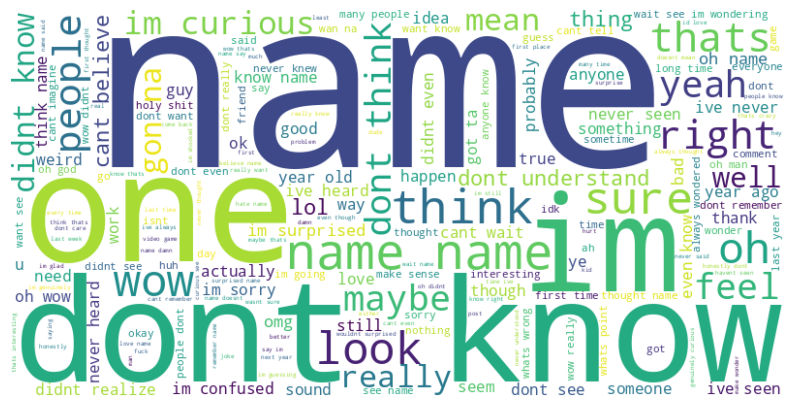

In [28]:
happy_text = data[data['sentiment'] == 'surprise']['processed_text'].str.cat(sep=' ')

# Créer le nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(happy_text)

# Afficher le nuage de mots
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# *Text Vectorization*

In [29]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(data['processed_text'])
sequences = tokenizer.texts_to_sequences(data['processed_text'])
word_index = tokenizer.word_index
X = pad_sequences(sequences, maxlen=100)

In [30]:
le = LabelEncoder()
data['sentiment'] = le.fit_transform(data['sentiment'])

In [31]:
le.classes_

array(['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype=object)

## *Splitting The Data*

In [32]:
Y=data['sentiment']

In [33]:
x_train,x_test,y_train,y_test=train_test_split(X,Y, test_size=0.2, random_state=1)

In [34]:
print('Shape Of Training Data',x_train.shape, y_train.shape)
print('Shape Of Testing Data',x_test.shape, y_test.shape)

Shape Of Training Data (408801, 100) (408801,)
Shape Of Testing Data (102201, 100) (102201,)


# *Loading Pre-Trained Glove Word Embedding*

In [35]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

embedding_index = {}
with open('./glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [36]:
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# *Model Building*

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten

# Définir le modèle
model = Sequential()

# Couche Embedding
model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=100,
                    trainable=False))

# Couche LSTM
model.add(LSTM(128, return_sequences=True))  # Première couche LSTM avec retour de séquences
model.add(Dropout(0.3))  # Dropout pour régularisation

model.add(LSTM(128))  # Deuxième couche LSTM
model.add(Dropout(0.3))

# Couches Denses pour la classification
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(le.classes_), activation='softmax'))  # Couche de sortie

# Compilation du modèle
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


*Model Summary*

In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       3,364,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,364,000 (12.83 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,364,000 (12.83 MB)

*Model Compilation*

In [39]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

*Model Training*

In [40]:
history  = model.fit(x_train, y_train, batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
10220/10220 ━━━━━━━━━━━━━━━━━━━━ 148s 14ms/step - accuracy: 0.4298 - loss: 1.4514 - val_accuracy: 0.5157 - val_loss: 1.2635
Epoch 2/30
10220/10220 ━━━━━━━━━━━━━━━━━━━━ 136s 13ms/step - accuracy: 0.5322 - loss: 1.2265 - val_accuracy: 0.5612 - val_loss: 1.1387
Epoch 3/30
10220/10220 ━━━━━━━━━━━━━━━━━━━━ 141s 13ms/step - accuracy: 0.5694 - loss: 1.1269 - val_accuracy: 0.5858 - val_loss: 1.0842
Epoch 4/30
10220/10220 ━━━━━━━━━━━━━━━━━━━━ 147s 14ms/step - accuracy: 0.5906 - loss: 1.0737 - val_accuracy: 0.6045 - val_loss: 1.0409
Epoch 5/30
10220/10220 ━━━━━━━━━━━━━━━━━━━━ 196s 14ms/step - accuracy: 0.6073 - loss: 1.0352 - val_accuracy: 0.6050 - val_loss: 1.0353
Epoch 6/30
10220/10220 ━━━━━━━━━━━━━━━━━━━━ 140s 14ms/step - accuracy: 0.6209 - loss: 1.0049 - val_accuracy: 0.6243 - val_loss: 0.9933
Epoch 7/30
10220/10220 ━━━━━━━━━━━━━━━━━━━━ 141s 14ms/step - accuracy: 0.6305 - loss: 0.9785 - val_accuracy: 0.6327 - val_loss: 0.9758
Epoch 8/30
10220/10220 ━━━━━━━━━━━━━━━━━━━━ 142s 14ms/s

# *Model Predictions*

In [41]:
y_pred = model.predict(x_test)

3194/3194 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step


# *Model Evaluation*

In [42]:
model.evaluate(x_test,y_test)

3194/3194 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.6689 - loss: 0.8902


[0.8920541405677795, 0.6684181094169617]

# *Model Saving*

In [43]:
save_model(model,'sentiment model.h5')

# *Saving the Tokenizer*

In [44]:
joblib.dump(tokenizer, "text_tokenizer.joblib")

['text_tokenizer.joblib']

In [45]:
y_test

,sentiment
360042,4
91919,3
249538,0
289129,5
183808,0
...,...
32206,2
500052,1
416469,4
22468,2


In [46]:
y_pred

array([[1.0110878e-03, 6.2163541e-05, 8.4974905e-03, 2.4132106e-02,
        9.6590906e-01, 3.8817144e-04],
       [1.8026371e-02, 1.1529721e-04, 1.6791388e-01, 6.4300787e-01,
        1.0080022e-02, 1.6085656e-01],
       [2.2827092e-01, 1.9631553e-03, 4.7043204e-02, 8.8624783e-02,
        5.7446241e-01, 5.9635509e-02],
       ...,
       [2.3596024e-02, 4.5645670e-06, 4.5130637e-02, 2.6423458e-02,
        9.0275109e-01, 2.0942283e-03],
       [2.5131243e-01, 2.5552968e-04, 2.9363692e-02, 5.9259754e-02,
        3.8632303e-03, 6.5594542e-01],
       [4.1003472e-01, 5.9889397e-04, 3.5408180e-02, 2.1138968e-02,
        4.5414260e-01, 7.8676678e-02]], dtype=float32)

In [47]:
y_pred_classes = y_pred.argmax(axis=1)
y_pred_classes

array([4, 3, 4, ..., 4, 5, 4])

Visualisation

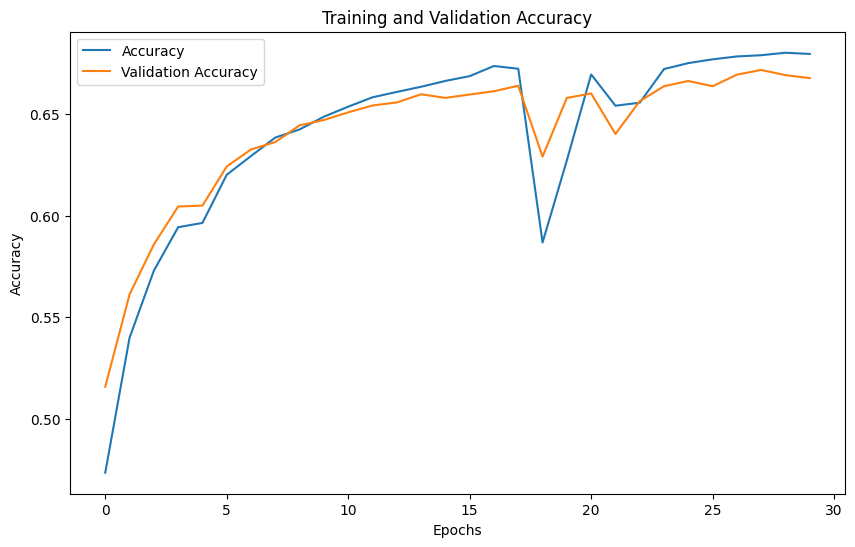

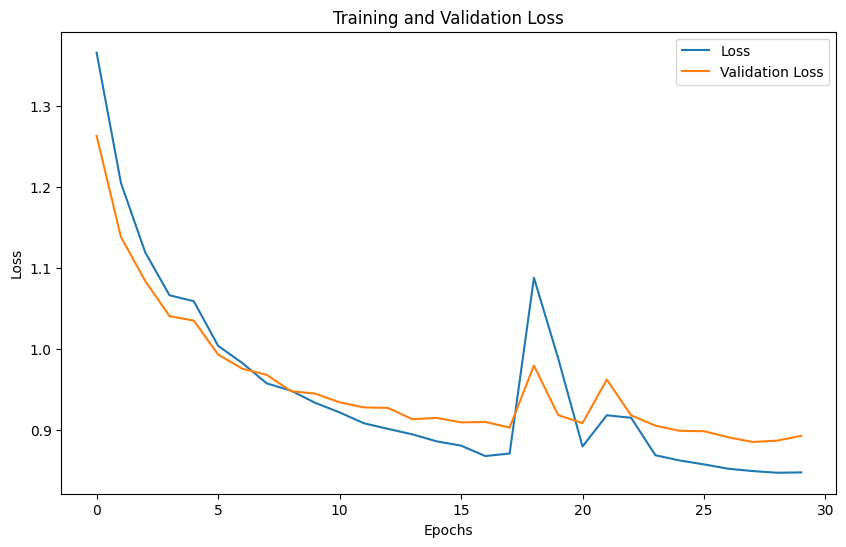

In [48]:
import matplotlib.pyplot as plt

# Visualisation des performances
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Visualisation de la perte
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


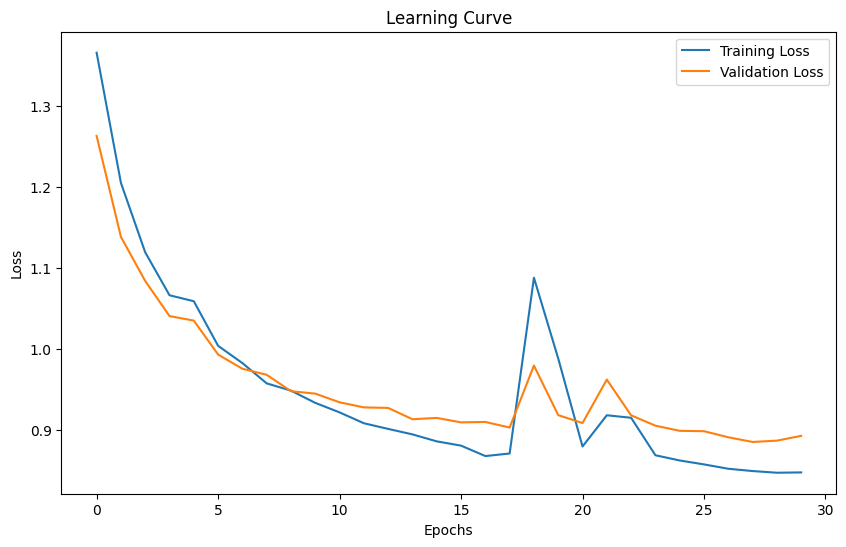

In [49]:
#graphe d'apprentissage

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Courbe d'apprentissage de la perte
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.legend()
plt.title("Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# *Making Some Predictions*

In [56]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Texte à prédire
text = "Hello I am Mitesh Gupta and I am glad to see you"

# Convertir le texte en séquences avec le tokenizer
word_token = tokenizer.texts_to_sequences([text])  # Utilisez texts_to_sequences

# Ajouter un padding à la séquence
padded_text = pad_sequences(word_token, padding='post', maxlen=100)

# Effectuer la prédiction
pred = model.predict(padded_text)

predicted_class = pred.argmax(axis=-1)  # Index de la classe prédite
print(f"Classe prédite : {predicted_class[0]}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Classe prédite : 4


In [57]:
from sklearn.preprocessing import LabelEncoder

# Supposez que 'le' est votre LabelEncoder utilisé lors de l'entraînement
# Exemples d'encodage : le.fit(y_train) avant l'entraînement
predicted_class_index = pred.argmax(axis=-1)  # Index de la classe prédite

# Convertir l'index en nom de classe
predicted_class_name = le.inverse_transform([predicted_class_index[0]])[0]

print(f"Classe prédite : {predicted_class_name}")


Classe prédite : sad


In [52]:
# ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Test

In [53]:
from keras.models import load_model
import joblib
from keras.preprocessing.sequence import pad_sequences

In [58]:
model=load_model('sentiment model.h5')
tokenizer=joblib.load('/content/text_tokenizer.joblib')
classes=['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [59]:
def predict_sentiment(text):
    sequences = tokenizer.texts_to_sequences([text])
    X = pad_sequences(sequences, maxlen=100)
    pred=model.predict(X,verbose=0)
    result=classes[pred.argmax()]
    return result

text="I am so happy"
print(predict_sentiment(text))

happy


In [1]:
from tensorflow.keras.models import load_model

# Charger le modèle sauvegardé
model = load_model('/content/sentiment model (1).h5')

# Afficher le résumé du modèle
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (32, 100, 100)              │       3,364,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (32, 100, 128)              │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 100, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (32, 128)                   │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (32, 128)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 128)                   │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 64)                    │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 6)                     │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,637,992 (13.88 MB)

 Trainable params: 273,990 (1.05 MB)

 Non-trainable params: 3,364,000 (12.83 MB)

 Optimizer params: 2 (12.00 B)